# Visualization for wn18RR results

In [1]:
import numpy as np
import pandas as pd
import config
from rule_comparison import plot_pie_chart, get_common_rules, display_comparison, get_unique_rules
from operator import itemgetter
from kb_extension import extend_kb

# random slection of candidates
import models
from rule_mining import rule_mining
from ampligraph.latent_features import RandomBaseline

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# family dataset
#original_kb = np.loadtxt(config.family_dataset_path, dtype = 'object')
#relations = config.family_relations
#folder_path = "./family_max_entities_200/"

# wn18rr dataset
original_kb = np.loadtxt(config.wn18rr_dataset_path, dtype = 'object')
relations = config.wn18rr_relations
folder_path = "./wn18rr_max_entities_1000/"

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


## Load and view raw data

In [2]:
# load saved rules
original_rules = pd.read_pickle(folder_path + "original_rules.pkl")
mined_rules = pd.read_pickle(folder_path + "mined_rules.pkl")
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters.pkl")
parameter_combinations = pd.read_pickle(folder_path + "parameter_combinations.pkl")
extension_sizes = pd.read_pickle(folder_path + "extension_sizes.pkl")

original_rules_median_PCA = original_rules["PCA Confidence"].median()
original_rules_median_HC = original_rules["Head Coverage"].median()

In [3]:
mined_rules_parameters

,Rule,Head Coverage,PCA Confidence,Positive Examples,PCA Body size,_Head Coverage,_PCA Confidence,_Positive Examples,_PCA Body size,PCA Diff,Pos Diff,Neg Diff,Entity_selection,Model,Candidate_criteria
0,?b _derivationally_related_form ?a => ?a ...,1.000000,1.000000,31865,31865,0.999030,0.999249,31927.0,31951.0,0.000751,-62.0,-24.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
1,?a _has_part ?h ?h _synset_domain_topic_of...,0.015325,0.809524,51,63,0.018756,0.797468,63.0,79.0,0.012055,-12.0,-4.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
2,?a _instance_hypernym ?g ?g _member_merony...,0.000000,0.000000,0,143,0.274224,0.673930,866.0,1285.0,-0.673930,-866.0,-276.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
3,?a _derivationally_related_form ?h ?h _syn...,0.041466,0.492857,138,280,0.041977,0.466887,141.0,302.0,0.025970,-3.0,-19.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
4,?a _instance_hypernym ?h ?h _synset_domain...,0.037560,0.886525,125,141,0.037809,0.814103,127.0,156.0,0.072422,-2.0,-13.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,?a _has_part ?h ?b _instance_hypernym ?h ...,0.035081,0.532544,180,338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules
6,?g _hypernym ?a ?g _synset_domain_topic_of...,0.098257,0.726667,327,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules
7,?a _hypernym ?h ?h _synset_domain_topic_of...,0.213942,0.828871,712,859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules
8,?g _derivationally_related_form ?a ?g _syn...,0.041466,0.492857,138,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules


<AxesSubplot:title={'center':'Difference in PCA confidence on original dataset vs extended dataset'}, ylabel='Frequency'>

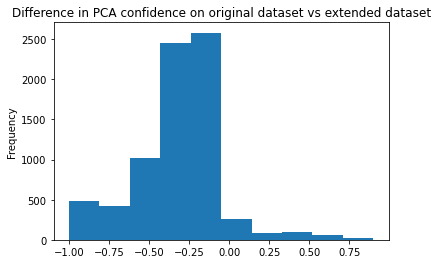

In [69]:
mined_rules_parameters['PCA Diff'].plot.hist(title = "Difference in PCA confidence on original dataset vs extended dataset")

<AxesSubplot:title={'center':'Difference in PCA confidence on original dataset vs extended dataset'}, ylabel='Frequency'>

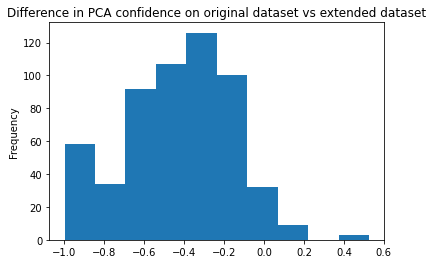

In [70]:
mined_rules_parameters_temp = mined_rules_parameters.loc[((mined_rules_parameters["Candidate_criteria"] == "('rank_cutoff', 1)") | (mined_rules_parameters["Candidate_criteria"] == 'Original rules') | (mined_rules_parameters["Candidate_criteria"] == 'Rand cand')) & (mined_rules_parameters["Entity_selection"] == 'least_frequent')]
mined_rules_parameters_temp['PCA Diff'].plot.hist(title = "Difference in PCA confidence on original dataset vs extended dataset")

### Examine size of kb extension

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


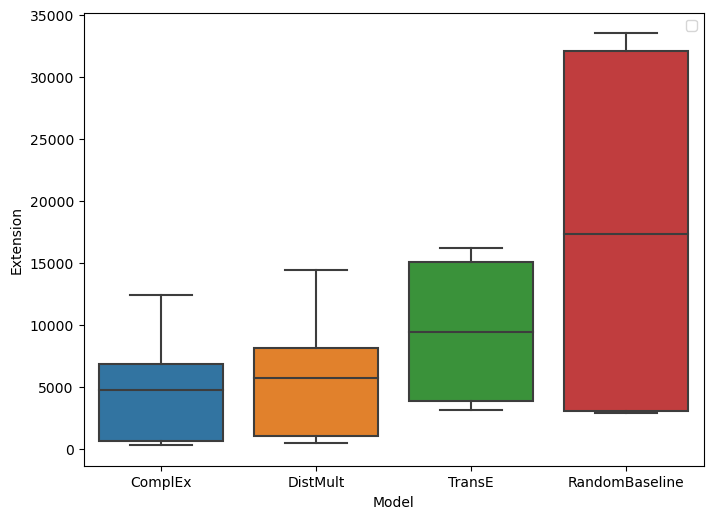

In [72]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="Extension", data=extension_sizes)
plt.legend()

## Add true randombasleine
Randomly select candidates and mine rules from the resulting expanded kb. The number of candidates to randomly add is the mean of the number of candidates added by ComplEx ranking.

In [ ]:
# used to determine the number of candidates to randomly add to kb
mean_complEx_extension_size = int(extension_sizes.loc[extension_sizes["Model"] == 'ComplEx'].Extension.mean())

# construct filler model
filler_model = RandomBaseline()
filler_model.fit(original_kb)

# add rules mined from randomly selected candidates
extended_kb, admitted_candidates = extend_kb(original_kb, relations, filler_model, "random", ("random", mean_complEx_extension_size), max_entities=config.max_entities)
rules = rule_mining(extended_kb)
number_of_rules = len(rules)
parameter_list = ["Rand cand","Rand cand","Rand cand"]
parameter_full = [parameter_list for j in range(number_of_rules)]
parameter_full_df = pd.DataFrame(parameter_full, columns=["Entity_selection", "Model", "Candidate_criteria"])
original_rules_parameters= pd.concat([rules, parameter_full_df], axis=1)
#mined_rules.append(original_rules_parameters)
mined_rules_parameters = pd.concat([mined_rules_parameters,original_rules_parameters])

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/ampligraph/latent_features/models/EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':


In [ ]:
mined_rules_parameters.to_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [53]:
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [8]:
# limited to rules mined with candidates ranked 1
mined_rules_parameters = mined_rules_parameters.loc[((mined_rules_parameters["Candidate_criteria"] == "('rank_cutoff', 1)") | (mined_rules_parameters["Candidate_criteria"] == 'Original rules') | (mined_rules_parameters["Candidate_criteria"] == 'Rand cand')) & ((mined_rules_parameters["Entity_selection"] == 'least_frequent') | (mined_rules_parameters["Entity_selection"] == 'Rand cand'))]

## Parameter 1: embedding model

In [9]:
def get_dataframe_to_plot(all_rules, parameter_type, parameter_name):
    """
    Generate dataframe containing rules mined with certain parameter value
    """
    rules = all_rules.loc[(all_rules[parameter_type] == parameter_name)]
    return rules

### Parameter 1: KG embeddings

In [10]:
complEx_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "ComplEx")
distMult_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "DistMult")
transE_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "TransE")
randomBaseline_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "RandomBaseline")
#random_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "Rand cand")
random_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "Original rules")

<AxesSubplot:title={'center':'PCA difference for complEx'}, ylabel='Frequency'>

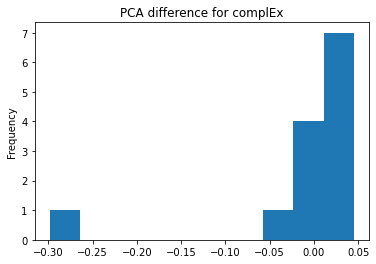

In [50]:
complEx_rules['PCA Diff'].plot.hist(title = "PCA difference for complEx")

<AxesSubplot:title={'center':'PCA difference for distMult'}, ylabel='Frequency'>

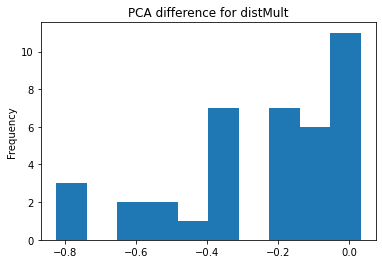

In [49]:
distMult_rules['PCA Diff'].plot.hist(title = "PCA difference for distMult")

<AxesSubplot:title={'center':'PCA difference for transE'}, ylabel='Frequency'>

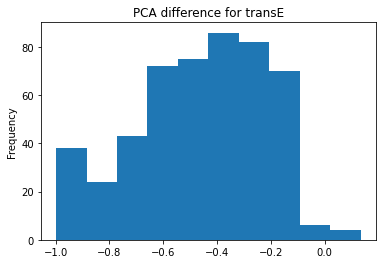

In [47]:
transE_rules['PCA Diff'].plot.hist(title = "PCA difference for transE")

<AxesSubplot:title={'center':'PCA difference for randomBaseline'}, ylabel='Frequency'>

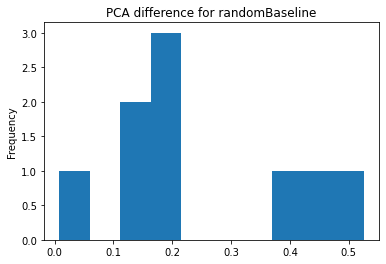

In [46]:
randomBaseline_rules['PCA Diff'].plot.hist(title = "PCA difference for randomBaseline")

In [36]:
complEx_PCA_mean = complEx_rules['PCA Confidence'].mean()
distMult_PCA_mean = distMult_rules['PCA Confidence'].mean()
transE_PCA_mean = transE_rules['PCA Confidence'].mean()
randomBaseline_PCA_mean = randomBaseline_rules['PCA Confidence'].mean()
random_PCA_mean = random_rules['PCA Confidence'].mean()

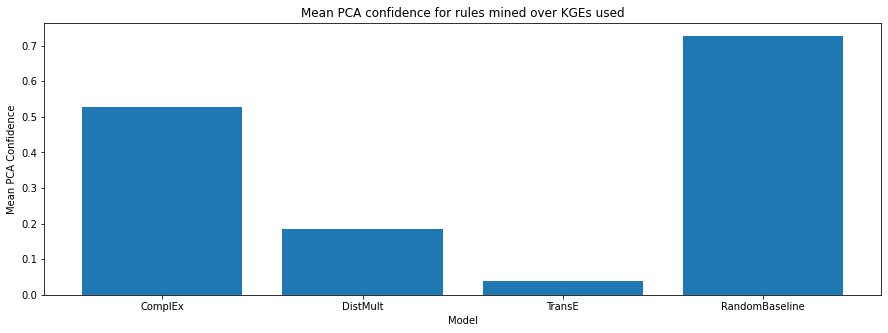

In [37]:
names = ["ComplEx", "DistMult", "TransE", "RandomBaseline", "Random"]
values = [complEx_PCA_mean, distMult_PCA_mean, transE_PCA_mean, randomBaseline_PCA_mean, random_PCA_mean]
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
plt.ylabel('Mean PCA Confidence')
plt.xlabel('Model')
plt.title("Mean PCA confidence for rules mined over KGEs used");


complEx
Mined 10/10 original rules, and 3 new rules.


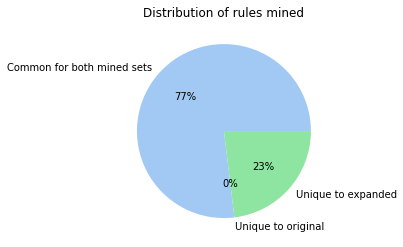


distMult
Mined 10/10 original rules, and 30 new rules.


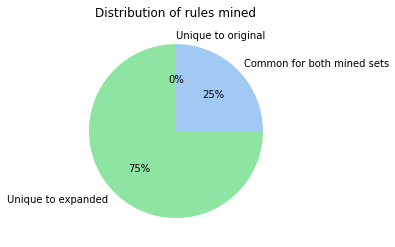


transE
Mined 10/10 original rules, and 607 new rules.


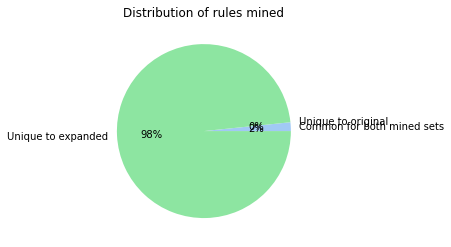


randomBaseline
Mined 9/10 original rules, and 0 new rules.
Rules missed:
?a  _has_part  ?h  ?b  _hypernym  ?h   => ?a  _has_part  ?b


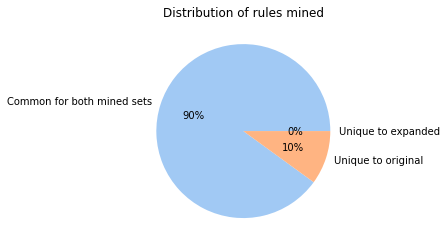


random
Mined 0/10 original rules, and 0 new rules.
Rules missed:
?b  _derivationally_related_form  ?a   => ?a  _derivationally_related_form  ?b
?a  _has_part  ?h  ?h  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?a  _instance_hypernym  ?h  ?h  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?g  _has_part  ?a  ?g  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?a  _derivationally_related_form  ?h  ?h  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?a  _has_part  ?h  ?b  _instance_hypernym  ?h   => ?a  _has_part  ?b
?g  _hypernym  ?a  ?g  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?a  _hypernym  ?h  ?h  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?g  _derivationally_related_form  ?a  ?g  _synset_domain_topic_of  ?b   => ?a  _synset_domain_topic_of  ?b
?a  _has_part  ?h  ?b  _hypernym  ?h   => ?a  _has_part  ?b


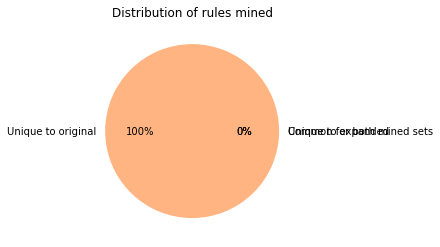

In [12]:
display_comparison("complEx", original_rules, complEx_rules.drop_duplicates("Rule"))
display_comparison("distMult", original_rules, distMult_rules.drop_duplicates("Rule"))
display_comparison("transE", original_rules, transE_rules.drop_duplicates("Rule"))
display_comparison("randomBaseline", original_rules, randomBaseline_rules.drop_duplicates("Rule"))
display_comparison("random", original_rules, random_rules.drop_duplicates("Rule"))

In [13]:
#def get_rule_distribution_dataframe(original_rules, mined_rules):
models = mined_rules_parameters.Model.unique()
rule_set_A = original_rules
rule_dist_df = pd.DataFrame([], columns = ["Model", "Not found", "Found", "New"])
for model in models:
    if model == "Original rules":
        continue
    rule_set_B = mined_rules_parameters.loc[(mined_rules_parameters['Model'] == model)].drop_duplicates(['Rule'])
    common = get_common_rules(rule_set_A, rule_set_B)
    unique_A, unique_B = get_unique_rules(rule_set_A, rule_set_B)
    common = len(common)
    len_unique_A = len(unique_A)
    len_unique_B = len(unique_B)
    append_df = pd.DataFrame([[model, len_unique_A, common, len_unique_B]], columns = ["Model", "Not found", "Found", "New"])
    rule_dist_df = rule_dist_df.append(append_df)
rule_dist_df

,Model,Not found,Found,New
0,ComplEx,0,10,3
0,DistMult,0,10,30
0,TransE,0,10,607
0,RandomBaseline,1,9,0


Text(4, -0.05, '10')

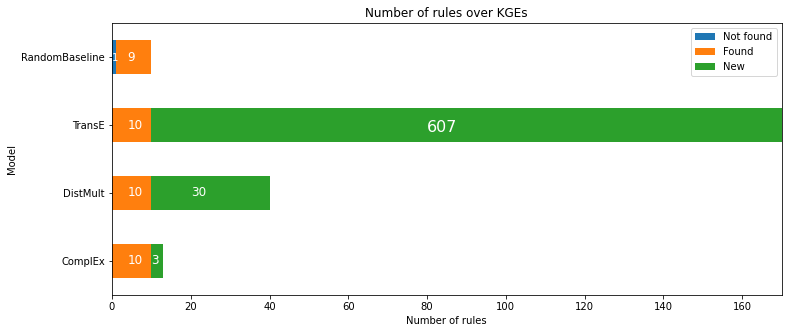

In [75]:
df = pd.DataFrame(rule_dist_df.set_index('Model'))
ax = df.plot.barh(figsize = (12, 5), title = "Number of rules over KGEs", stacked=True, xlim = (0,170), legend = True)
ax.set_xlabel('Number of rules')
randomBaseline_not_found_rules = 1 # TODO
ax.annotate(str(randomBaseline_not_found_rules), xy =(0.08,2.95), color = "white")
randomBaseline_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'RandomBaseline')].Found.values[0]
ax.annotate(str(randomBaseline_found_rules), xy =(4,2.95), color = "white", fontsize=12)
transE_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].New.values[0]
ax.annotate(str(transE_new_rules), xy =(80,1.9), color = "white", fontsize=16)
transE_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].Found.values[0]
ax.annotate(str(transE_found_rules), xy =(4,1.95), color = "white", fontsize=12)
distMult_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].New.values[0]
ax.annotate(str(distMult_new_rules), xy =(20,0.95), color = "white", fontsize=12)
distMult_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].Found.values[0]
ax.annotate(str(distMult_found_rules), xy =(4,0.95), color = "white", fontsize=12)
complEx_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].New.values[0]
ax.annotate(str(complEx_new_rules), xy =(10,-0.05), color = "white", fontsize=12)
complEx_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].Found.values[0]
ax.annotate(str(complEx_found_rules), xy =(4,-0.05), color = "white", fontsize=12)

In [15]:
def parse_rule(string_rule: str):
    list_rule = string_rule.split()
    body_1 = [list_rule[0], list_rule[1], list_rule[2]]
    body_parts = [body_1]
    if len(list_rule) > 7:
        body_2 = [list_rule[3], list_rule[4], list_rule[5]]
        body_parts.append(body_2)
        head = [list_rule[7], list_rule[8], list_rule[9]]
    else:
        head = [list_rule[4], list_rule[5], list_rule[6]]
    return body_parts, head

In [16]:
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

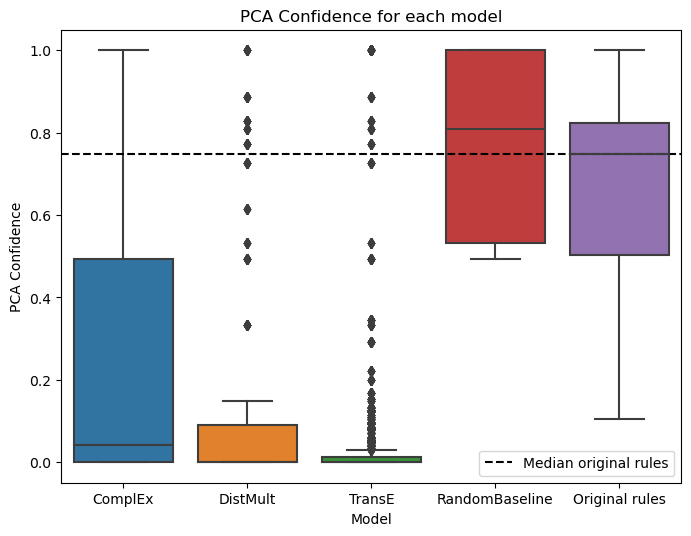

In [17]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.title("PCA Confidence for each model")
plt.legend()
plt.savefig("Max_entities=250_randcand=600_rank=1.png")

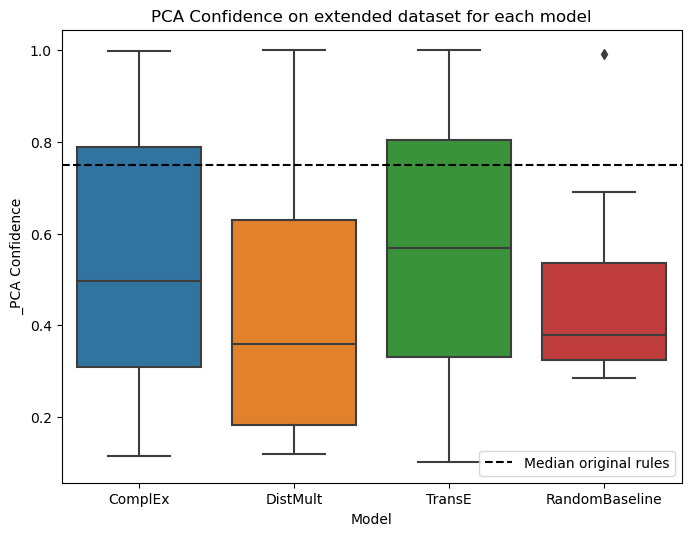

In [51]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="_PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.title("PCA Confidence on extended dataset for each model")
plt.legend()
plt.savefig("Max_entities=250_randcand=600_rank=1.png")

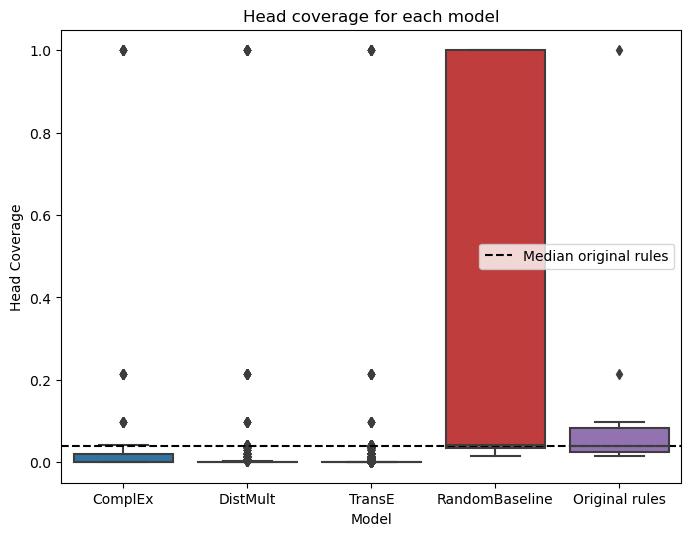

In [18]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for each model")
plt.legend()

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

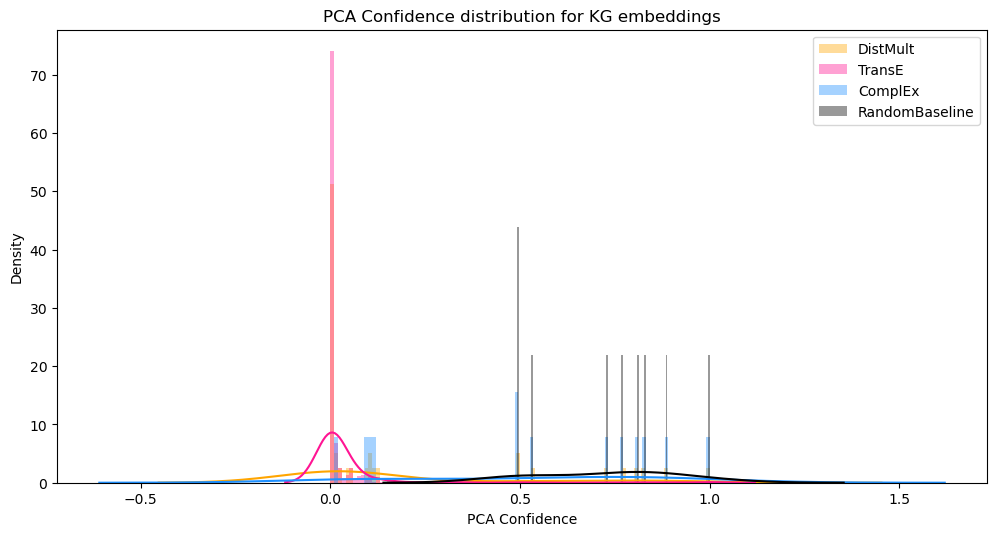

In [19]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(distMult_rules["PCA Confidence"] , color="orange", bins = 100, label="DistMult")
sns.distplot(transE_rules["PCA Confidence"] , color="deeppink", bins = 100, label="TransE")
sns.distplot(complEx_rules["PCA Confidence"] , color="dodgerblue", bins = 100, label="ComplEx")
sns.distplot(randomBaseline_rules["PCA Confidence"] , color="black", bins = 100, label="RandomBaseline")


plt.title('PCA Confidence distribution for KG embeddings')
plt.legend();

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

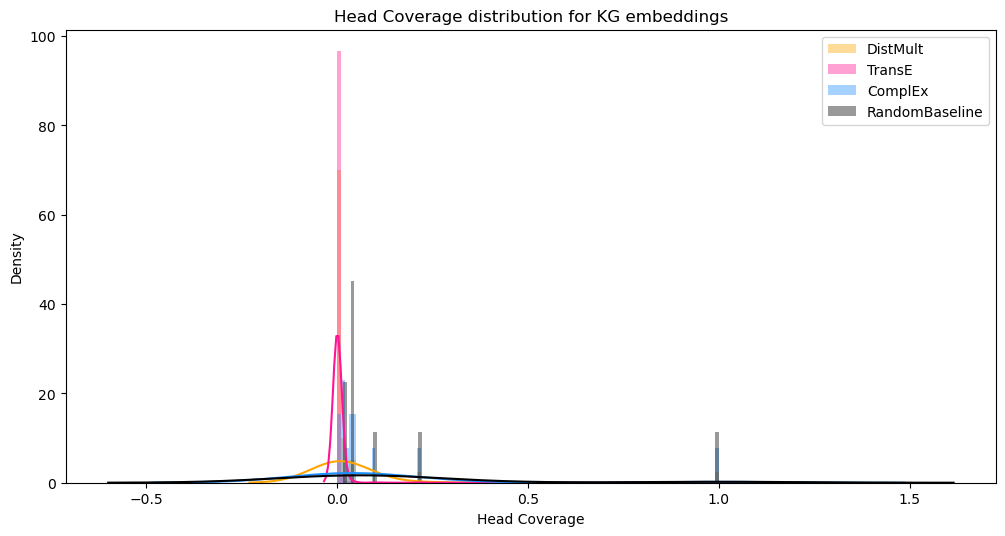

In [20]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(distMult_rules["Head Coverage"] , color="orange", bins = 100, label="DistMult")
sns.distplot(transE_rules["Head Coverage"] , color="deeppink", bins = 100, label="TransE")
sns.distplot(complEx_rules["Head Coverage"] , color="dodgerblue", bins = 100, label="ComplEx")
sns.distplot( randomBaseline_rules["Head Coverage"] , color="black", bins = 100, label="RandomBaseline")


plt.title('Head Coverage distribution for KG embeddings')
plt.legend();

### Parameter 2: entity selection method

In [56]:
random_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "random")
most_frequent_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "most_frequent")
least_frequent_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "least_frequent")
probabilistic_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "probabilistic")


Random selecction
Mined 10/10 original rules, and 789 new rules.


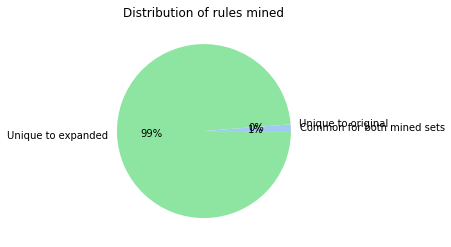


Most frequent
Mined 10/10 original rules, and 689 new rules.


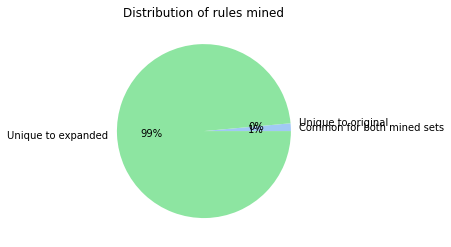


least frequent
Mined 10/10 original rules, and 937 new rules.


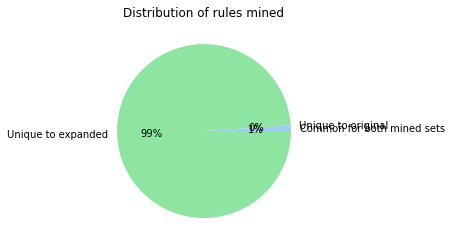


Probabilistic selection
Mined 10/10 original rules, and 739 new rules.


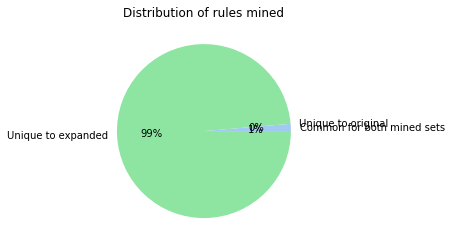

In [57]:
display_comparison("Random selecction", original_rules, random_entity_rules.drop_duplicates("Rule"))
display_comparison("Most frequent", original_rules, most_frequent_entity_rules.drop_duplicates("Rule"))
display_comparison("least frequent", original_rules, least_frequent_entity_rules.drop_duplicates("Rule"))
display_comparison("Probabilistic selection", original_rules, probabilistic_entity_rules.drop_duplicates("Rule"))

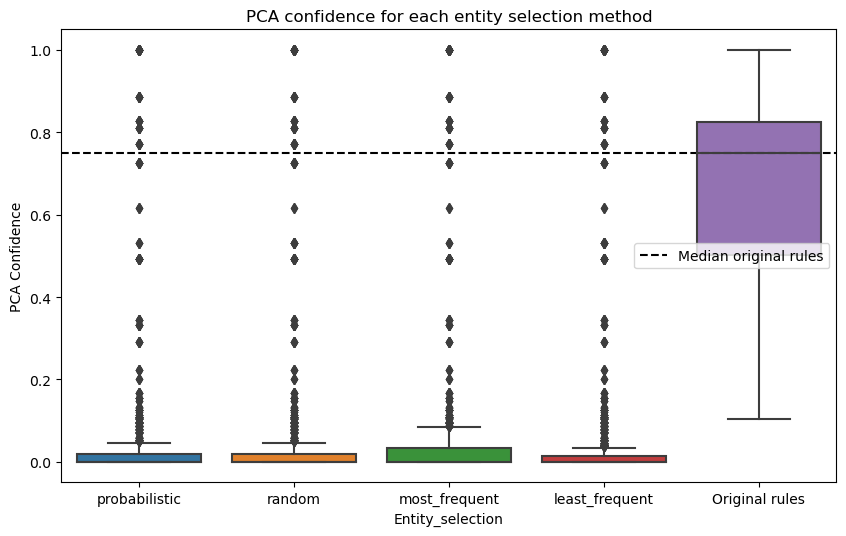

In [59]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence for each entity selection method")
plt.legend()

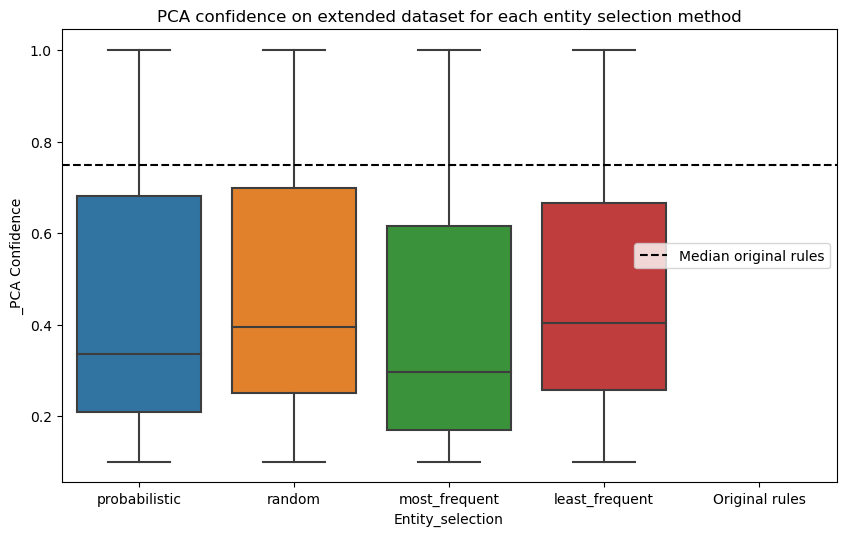

In [60]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="_PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence on extended dataset for each entity selection method")
plt.legend()

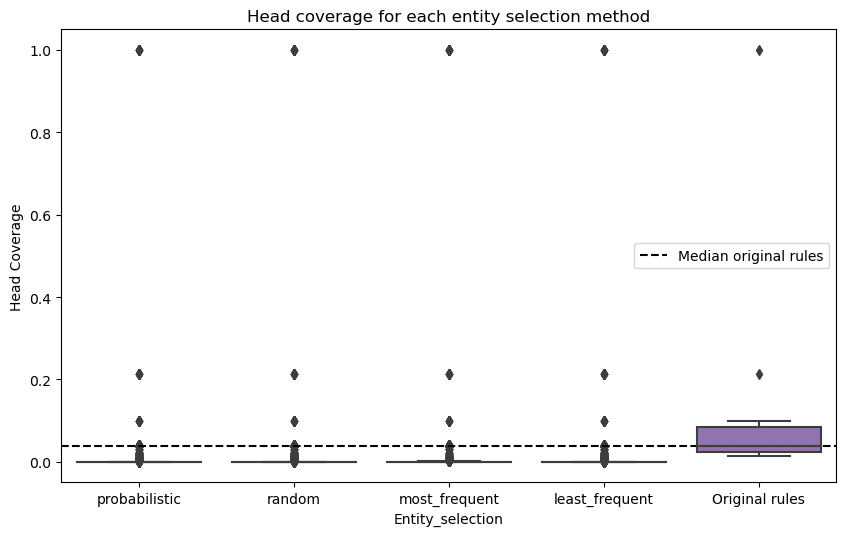

In [24]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for each entity selection method")
plt.legend()

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

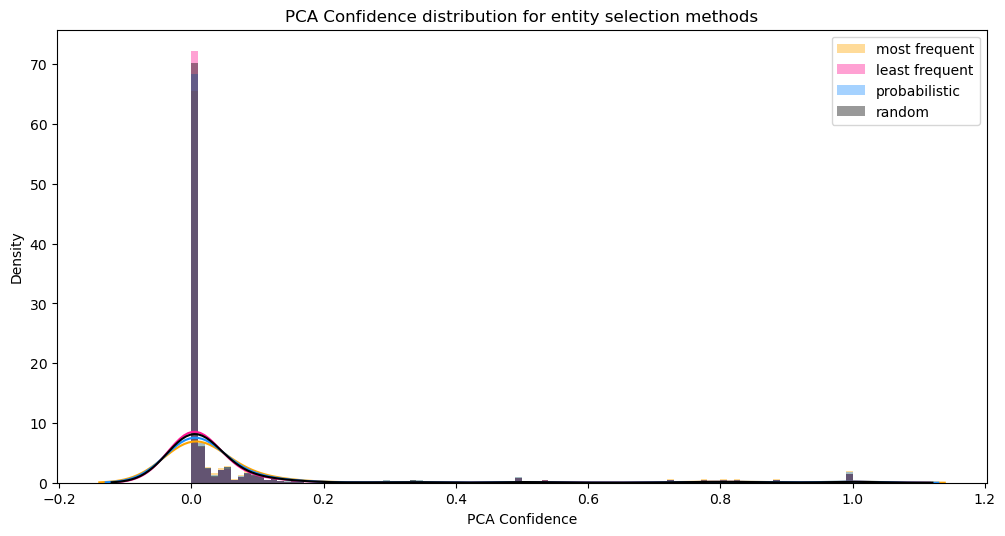

In [25]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(most_frequent_entity_rules["PCA Confidence"] , color="orange", bins = 100, label="most frequent")
sns.distplot(least_frequent_entity_rules["PCA Confidence"] , color="deeppink", bins = 100, label="least frequent")
sns.distplot( probabilistic_entity_rules["PCA Confidence"] , color="dodgerblue", bins = 100, label="probabilistic")
sns.distplot(random_entity_rules["PCA Confidence"] , color="black", bins = 100, label="random")


plt.title('PCA Confidence distribution for entity selection methods')
plt.legend();

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

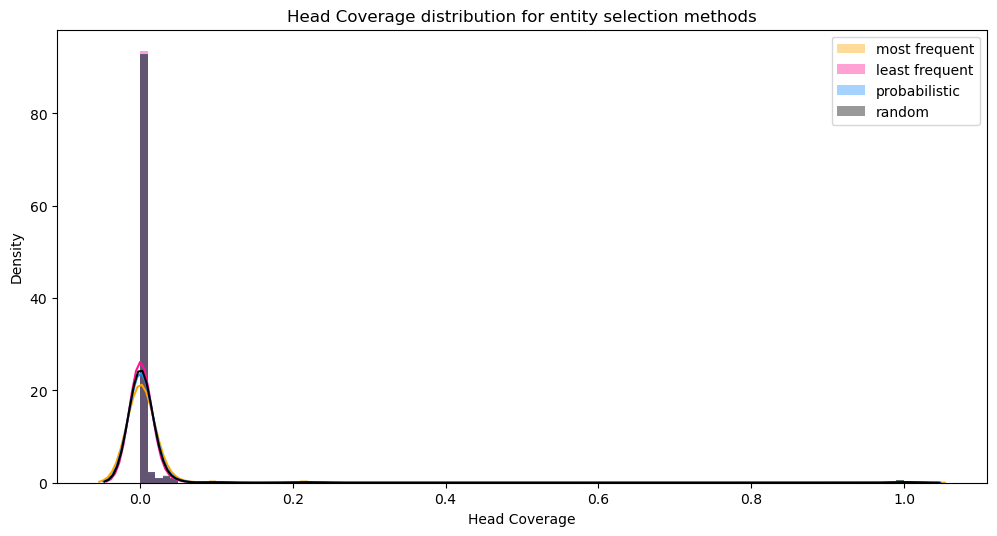

In [26]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(most_frequent_entity_rules["Head Coverage"] , color="orange", bins = 100, label="most frequent")
sns.distplot(least_frequent_entity_rules["Head Coverage"] , color="deeppink", bins = 100, label="least frequent")
sns.distplot( probabilistic_entity_rules["Head Coverage"] , color="dodgerblue", bins = 100, label="probabilistic")
sns.distplot(random_entity_rules["Head Coverage"] , color="black", bins = 100, label="random")


plt.title('Head Coverage distribution for entity selection methods')
plt.legend();

### Parameter 3: candidate admittance criteria


('rank_cutoff', 1)
Mined 10/10 original rules, and 708 new rules.


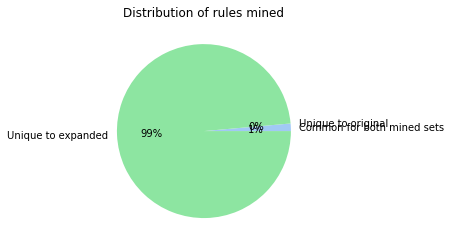


('rank_cutoff', 4)
Mined 10/10 original rules, and 898 new rules.


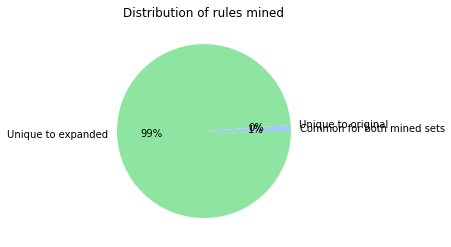


('rank_cutoff', 7)
Mined 10/10 original rules, and 942 new rules.


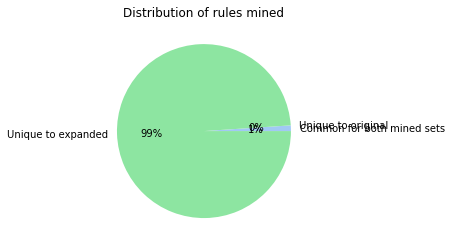

In [61]:
mined_rules_parameters['Candidate_criteria'] =  mined_rules_parameters.Candidate_criteria.astype(str)

for rank in config.rank_cutoffs:
    rank_df = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    display_comparison(str(rank), original_rules, rank_df.drop_duplicates("Rule"))

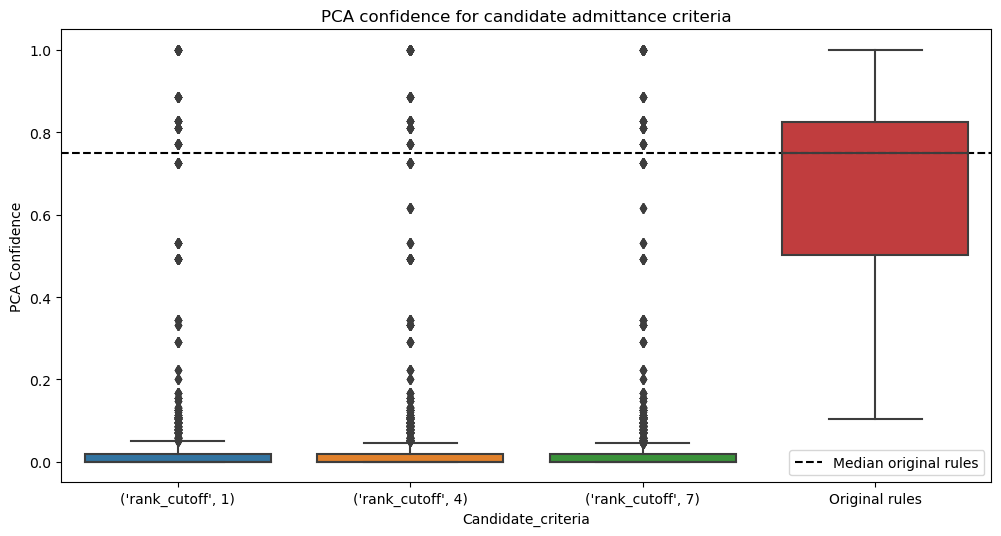

In [62]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence for candidate admittance criteria")
plt.legend()

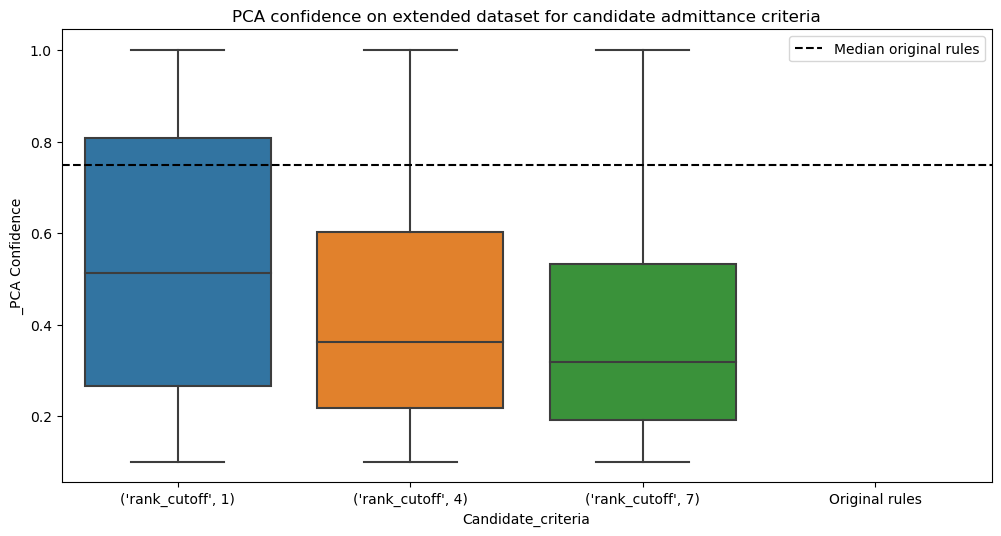

In [63]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="_PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence on extended dataset for candidate admittance criteria")

plt.legend()

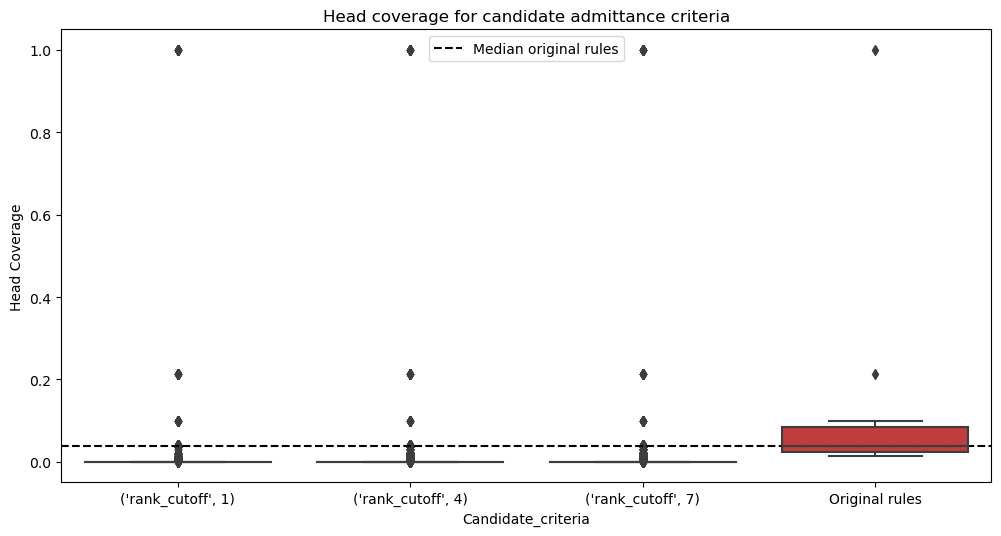

In [29]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for candidate admittance criteria")
plt.legend()

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

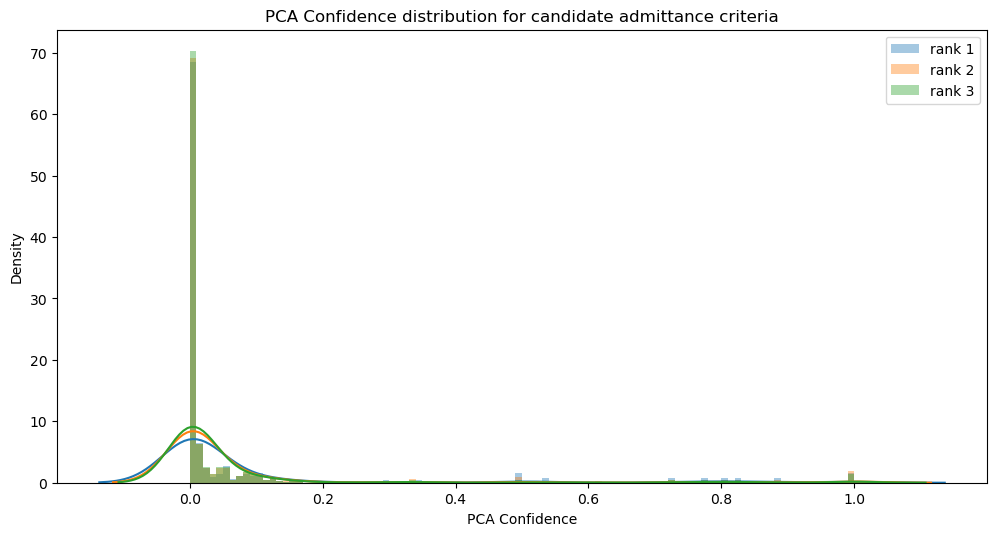

In [30]:
plt.subplots(figsize=(12,6), dpi=100)
for i, rank in enumerate(config.rank_cutoffs):
    rules_set = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    sns.distplot(rules_set["PCA Confidence"] , color=sns.color_palette()[i], bins = 100, label="rank " +str(i+1))
plt.title('PCA Confidence distribution for candidate admittance criteria')
plt.legend();

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

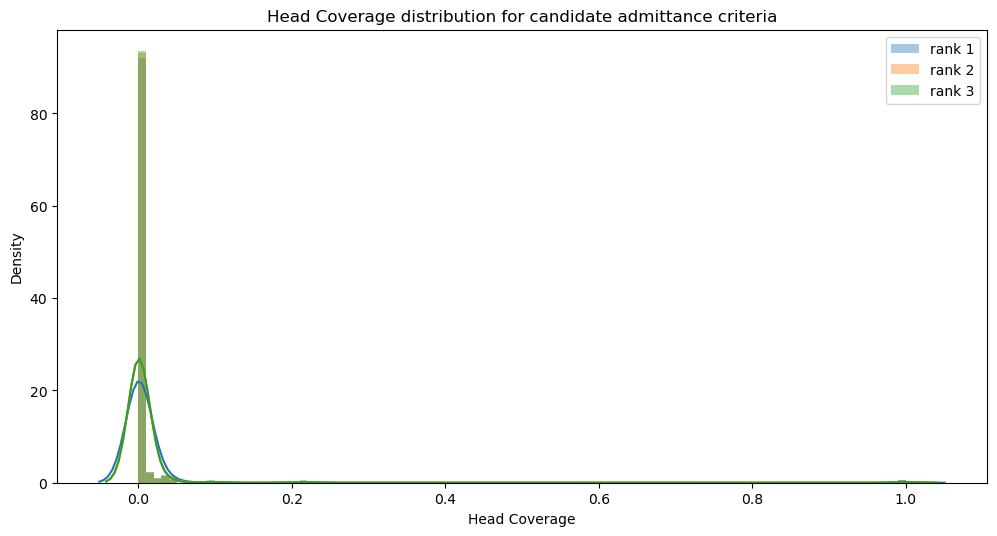

In [31]:
plt.subplots(figsize=(12,6), dpi=100)
for i, rank in enumerate(config.rank_cutoffs):
    rules_set = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    sns.distplot(rules_set["Head Coverage"] , color=sns.color_palette()[i], bins = 100, label="rank " +str(i+1))
plt.title('Head Coverage distribution for candidate admittance criteria')
plt.legend();

### PCA Confidence vs Head Coverage

These plots visualize too many datapoints so it is only confusing to look at these plots

In [64]:
def plot_scatterplot(mined_rules_df, parameter="Model"):
    plt.subplots(figsize=(12,6), dpi=100)
    plot = sns.scatterplot(data=mined_rules_df.sample(frac=1), x="PCA Confidence", y="Head Coverage", hue=parameter, alpha=1)
    #plot.set_xlim(0.09, 0.5)
    #plot.set_ylim(0, 0.16)
    plot.set_title("PCA Confidence vs Head coverage per " +parameter.lower())
    plt.legend()

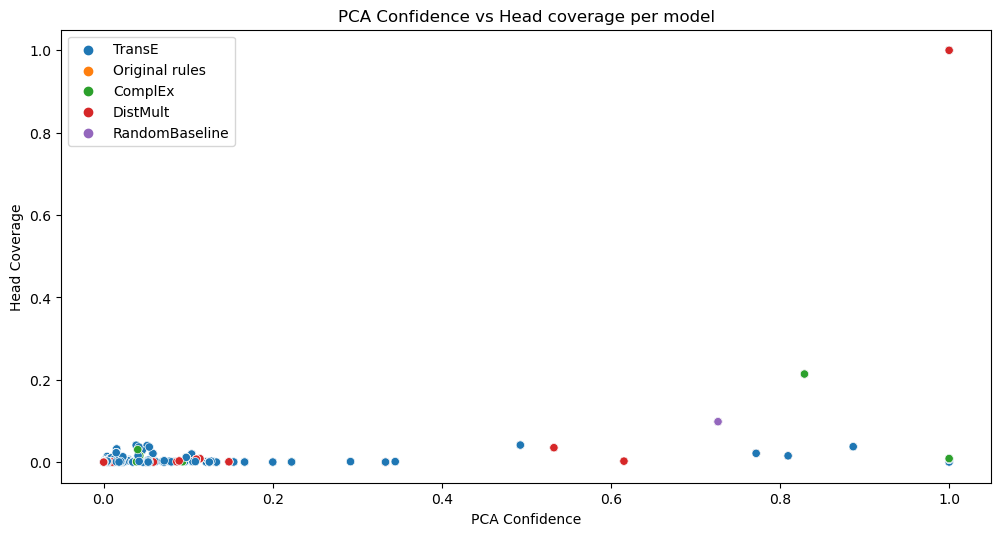

In [65]:
plot_scatterplot(mined_rules_parameters, parameter="Model")

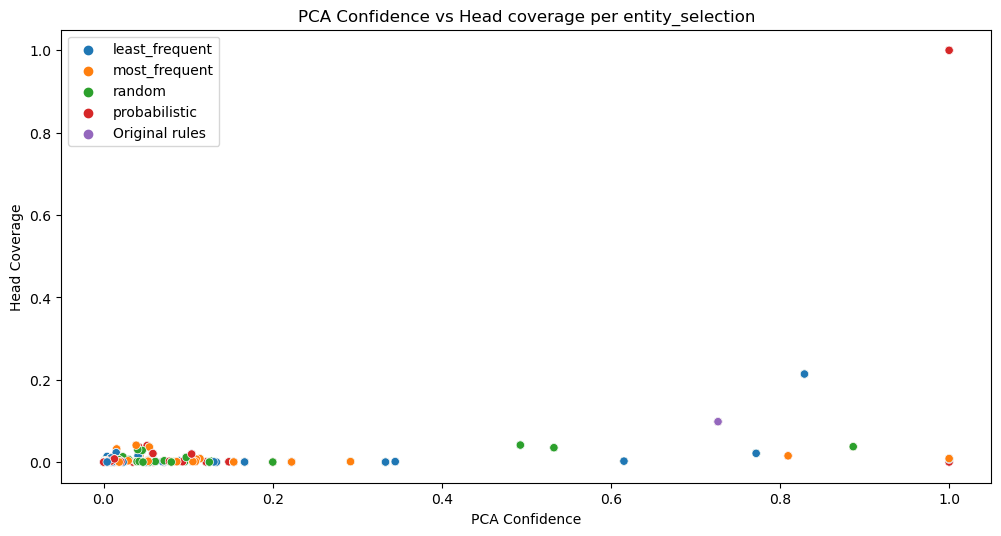

In [66]:
plot_scatterplot(mined_rules_parameters, parameter="Entity_selection")

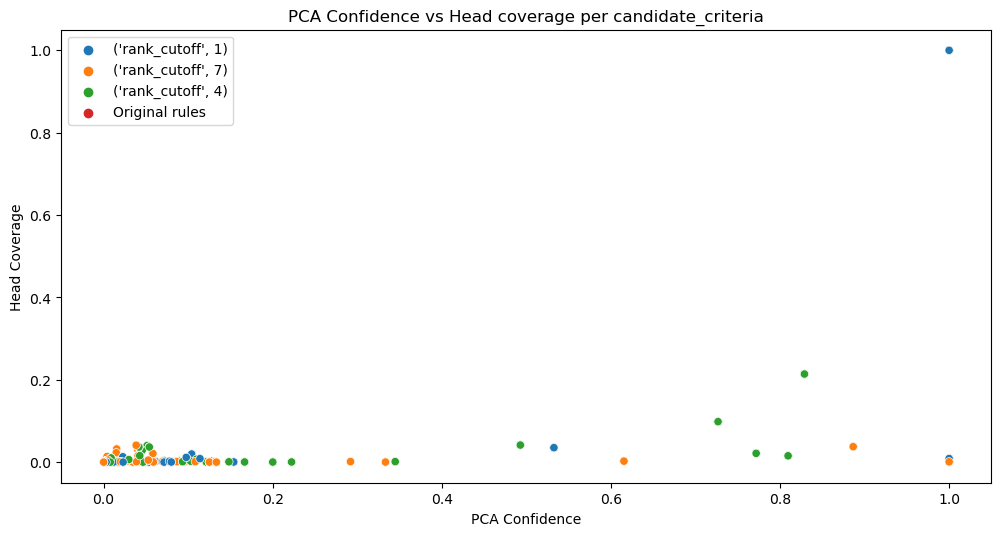

In [67]:
plot_scatterplot(mined_rules_parameters, parameter="Candidate_criteria")